# Random Forest Training & Trading Based on Trading Signals

---

### Import Libraries and Dependencies

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import _forest
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Trading Signal Features

---

### Read in CSV as Pandas DataFrame

In [2]:
# Set path to CSV and read in CSV
csv_path = Path('Resources/kraken_btc_1hr.csv')
btc_df=pd.read_csv(csv_path)
btc_df

,Timestamp,Open,High,Low,Close,Volume,Symbol
0,2019-08-26 17:00:00+00:00,10324.6,10333.9,10292.7,10300.0,134.471765,BTC/USD
1,2019-08-26 18:00:00+00:00,10300.0,10305.0,10261.0,10290.9,131.790626,BTC/USD
2,2019-08-26 19:00:00+00:00,10290.9,10325.1,10290.0,10310.0,78.294890,BTC/USD
3,2019-08-26 20:00:00+00:00,10311.5,10312.8,10147.5,10262.6,354.930190,BTC/USD
4,2019-08-26 21:00:00+00:00,10265.4,10308.1,10189.7,10274.6,570.039335,BTC/USD
...,...,...,...,...,...,...,...
715,2019-09-25 12:00:00+00:00,8336.7,8363.9,8000.0,8305.7,1295.424881,BTC/USD
716,2019-09-25 13:00:00+00:00,8305.7,8442.5,8278.0,8388.2,459.187772,BTC/USD
717,2019-09-25 14:00:00+00:00,8392.0,8478.4,8375.0,8379.0,466.040826,BTC/USD
718,2019-09-25 15:00:00+00:00,8385.4,8430.0,8294.5,8294.5,259.406669,BTC/USD


### Set Index, Infer DateTimeFormat, and Drop Extraneous Columns

In [3]:
# Set index as datetime object and drop extraneous columns
btc_df.set_index(pd.to_datetime(btc_df['Timestamp'], infer_datetime_format=True), inplace=True)
btc_df.drop(columns=['Timestamp'], inplace=True)
btc_df

,Open,High,Low,Close,Volume,Symbol
Timestamp,,,,,,
2019-08-26 17:00:00+00:00,10324.6,10333.9,10292.7,10300.0,134.471765,BTC/USD
2019-08-26 18:00:00+00:00,10300.0,10305.0,10261.0,10290.9,131.790626,BTC/USD
2019-08-26 19:00:00+00:00,10290.9,10325.1,10290.0,10310.0,78.294890,BTC/USD
2019-08-26 20:00:00+00:00,10311.5,10312.8,10147.5,10262.6,354.930190,BTC/USD
2019-08-26 21:00:00+00:00,10265.4,10308.1,10189.7,10274.6,570.039335,BTC/USD
...,...,...,...,...,...,...
2019-09-25 12:00:00+00:00,8336.7,8363.9,8000.0,8305.7,1295.424881,BTC/USD
2019-09-25 13:00:00+00:00,8305.7,8442.5,8278.0,8388.2,459.187772,BTC/USD
2019-09-25 14:00:00+00:00,8392.0,8478.4,8375.0,8379.0,466.040826,BTC/USD


### Drop NAs and Calculate Daily Returns

In [4]:
# Drop NAs and calculate daily percent return
btc_df['daily_return'] = btc_df['Close'].dropna().pct_change()
btc_df

,Open,High,Low,Close,Volume,Symbol,daily_return
Timestamp,,,,,,,
2019-08-26 17:00:00+00:00,10324.6,10333.9,10292.7,10300.0,134.471765,BTC/USD,NaN
2019-08-26 18:00:00+00:00,10300.0,10305.0,10261.0,10290.9,131.790626,BTC/USD,-0.000883
2019-08-26 19:00:00+00:00,10290.9,10325.1,10290.0,10310.0,78.294890,BTC/USD,0.001856
2019-08-26 20:00:00+00:00,10311.5,10312.8,10147.5,10262.6,354.930190,BTC/USD,-0.004597
2019-08-26 21:00:00+00:00,10265.4,10308.1,10189.7,10274.6,570.039335,BTC/USD,0.001169
...,...,...,...,...,...,...,...
2019-09-25 12:00:00+00:00,8336.7,8363.9,8000.0,8305.7,1295.424881,BTC/USD,-0.003957
2019-09-25 13:00:00+00:00,8305.7,8442.5,8278.0,8388.2,459.187772,BTC/USD,0.009933
2019-09-25 14:00:00+00:00,8392.0,8478.4,8375.0,8379.0,466.040826,BTC/USD,-0.001097


### Construct Exponential Moving Average of Closing Prices (Trading Signal, Feature One)

In [5]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
btc_df['fast_close'] = btc_df['Close'].ewm(halflife=short_window).mean()
btc_df['slow_close'] = btc_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
btc_df['crossover_long'] = np.where(btc_df['fast_close'] > btc_df['slow_close'], 1.0, 0.0)
btc_df['crossover_short'] = np.where(btc_df['fast_close'] < btc_df['slow_close'], -1.0, 0.0)
btc_df['crossover_signal'] = btc_df['crossover_long'] + btc_df['crossover_short']

btc_df.head()

,Open,High,Low,Close,Volume,Symbol,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Timestamp,,,,,,,,,,,,
2019-08-26 17:00:00+00:00,10324.6,10333.9,10292.7,10300.0,134.471765,BTC/USD,NaN,10300.000000,10300.000000,0.0,0.0,0.0
2019-08-26 18:00:00+00:00,10300.0,10305.0,10261.0,10290.9,131.790626,BTC/USD,-0.000883,10293.933333,10295.292372,0.0,-1.0,-1.0
2019-08-26 19:00:00+00:00,10290.9,10325.1,10290.0,10310.0,78.294890,BTC/USD,0.001856,10303.114286,10300.538382,1.0,0.0,1.0
2019-08-26 20:00:00+00:00,10311.5,10312.8,10147.5,10262.6,354.930190,BTC/USD,-0.004597,10281.506667,10290.046097,0.0,-1.0,-1.0
2019-08-26 21:00:00+00:00,10265.4,10308.1,10189.7,10274.6,570.039335,BTC/USD,0.001169,10277.941935,10286.514507,0.0,-1.0,-1.0


### Plot Exponential Moving Average of Closing Prices

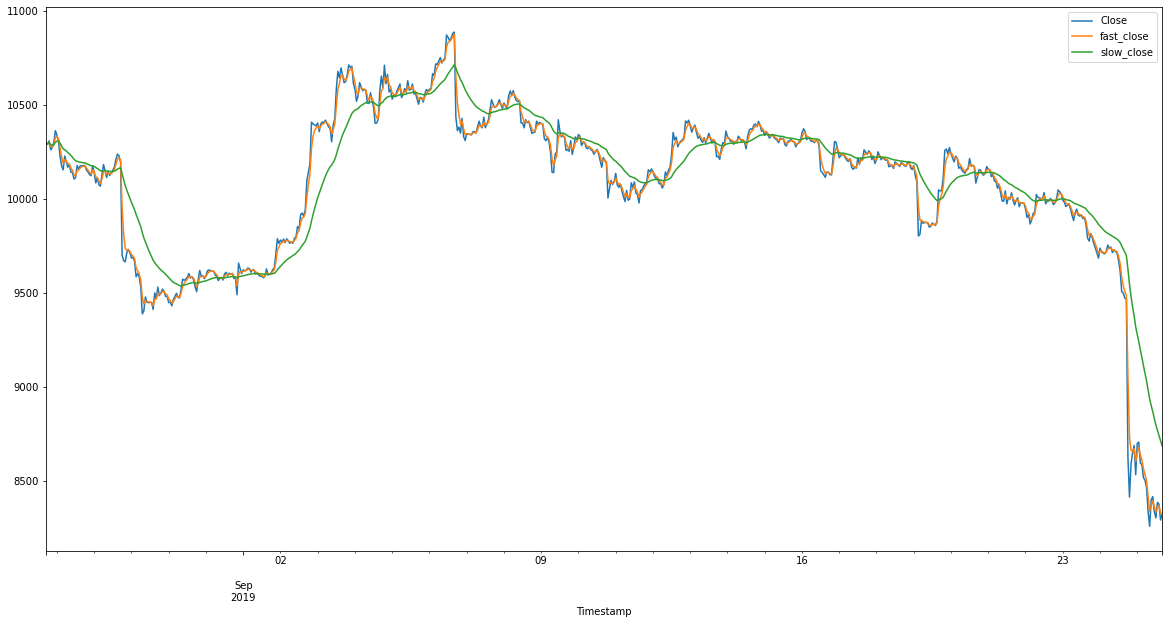

In [6]:
# Plot the EMA of BTC/USD closing prices
btc_df[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10));

### Construct Exponential Moving Average of Daily Return Volatility (Trading Signal, Feature Two)

In [7]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
btc_df['fast_vol'] = btc_df['daily_return'].ewm(halflife=short_vol_window).std()
btc_df['slow_vol'] = btc_df['daily_return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
btc_df['vol_trend_long'] = np.where(btc_df['fast_vol'] < btc_df['slow_vol'], 1.0, 0.0)
btc_df['vol_trend_short'] = np.where(btc_df['fast_vol'] > btc_df['slow_vol'], -1.0, 0.0) 
btc_df['vol_trend_signal'] = btc_df['vol_trend_long'] + btc_df['vol_trend_short']

btc_df

,Open,High,Low,Close,Volume,Symbol,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Timestamp,,,,,,,,,,,,,,,,,
2019-08-26 17:00:00+00:00,10324.6,10333.9,10292.7,10300.0,134.471765,BTC/USD,NaN,10300.000000,10300.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2019-08-26 18:00:00+00:00,10300.0,10305.0,10261.0,10290.9,131.790626,BTC/USD,-0.000883,10293.933333,10295.292372,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0
2019-08-26 19:00:00+00:00,10290.9,10325.1,10290.0,10310.0,78.294890,BTC/USD,0.001856,10303.114286,10300.538382,1.0,0.0,1.0,0.001937,0.001937,0.0,0.0,0.0
2019-08-26 20:00:00+00:00,10311.5,10312.8,10147.5,10262.6,354.930190,BTC/USD,-0.004597,10281.506667,10290.046097,0.0,-1.0,-1.0,0.003796,0.003300,0.0,-1.0,-1.0
2019-08-26 21:00:00+00:00,10265.4,10308.1,10189.7,10274.6,570.039335,BTC/USD,0.001169,10277.941935,10286.514507,0.0,-1.0,-1.0,0.003283,0.002938,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-25 12:00:00+00:00,8336.7,8363.9,8000.0,8305.7,1295.424881,BTC/USD,-0.003957,8336.263582,8799.354978,0.0,-1.0,-1.0,0.008004,0.015465,1.0,0.0,1.0
2019-09-25 13:00:00+00:00,8305.7,8442.5,8278.0,8388.2,459.187772,BTC/USD,0.009933,8362.231791,8771.821159,0.0,-1.0,-1.0,0.010050,0.015345,1.0,0.0,1.0
2019-09-25 14:00:00+00:00,8392.0,8478.4,8375.0,8379.0,466.040826,BTC/USD,-0.001097,8370.615896,8745.515101,0.0,-1.0,-1.0,0.007568,0.014830,1.0,0.0,1.0


### Plot Exponential Moving Average of Daily Return Volatility

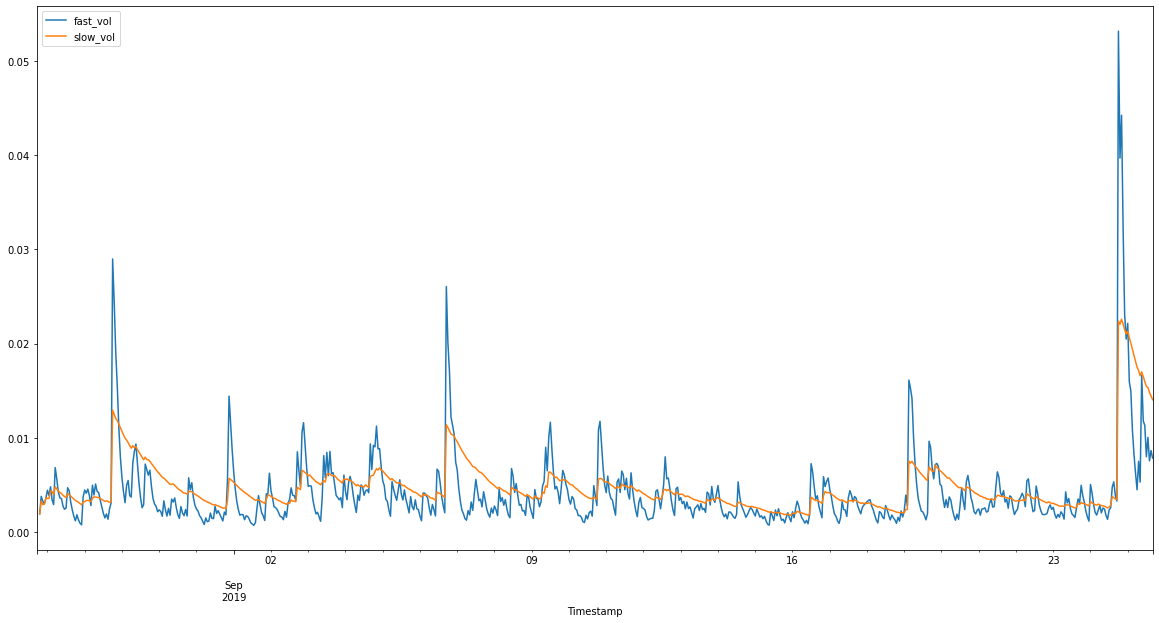

In [8]:
# Plot the EMA of BTC/USD daily return volatility
btc_df[['fast_vol', 'slow_vol']].plot(figsize=(20,10));

### Construct Bollinger Band (Trading Signal, Feature Three)

In [9]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
btc_df['bollinger_mid_band'] = btc_df['Close'].rolling(window=bollinger_window).mean()
btc_df['bollinger_std'] = btc_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
btc_df['bollinger_upper_band']  = btc_df['bollinger_mid_band'] + (btc_df['bollinger_std'] * 1)
btc_df['bollinger_lower_band']  = btc_df['bollinger_mid_band'] - (btc_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
btc_df['bollinger_long'] = np.where(btc_df['Close'] < btc_df['bollinger_lower_band'], 1.0, 0.0)
btc_df['bollinger_short'] = np.where(btc_df['Close'] > btc_df['bollinger_upper_band'], -1.0, 0.0)
btc_df['bollinger_signal'] = btc_df['bollinger_long'] + btc_df['bollinger_short']

btc_df

,Open,High,Low,Close,Volume,Symbol,daily_return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-08-26 17:00:00+00:00,10324.6,10333.9,10292.7,10300.0,134.471765,BTC/USD,NaN,10300.000000,10300.000000,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-08-26 18:00:00+00:00,10300.0,10305.0,10261.0,10290.9,131.790626,BTC/USD,-0.000883,10293.933333,10295.292372,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-08-26 19:00:00+00:00,10290.9,10325.1,10290.0,10310.0,78.294890,BTC/USD,0.001856,10303.114286,10300.538382,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-08-26 20:00:00+00:00,10311.5,10312.8,10147.5,10262.6,354.930190,BTC/USD,-0.004597,10281.506667,10290.046097,0.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-08-26 21:00:00+00:00,10265.4,10308.1,10189.7,10274.6,570.039335,BTC/USD,0.001169,10277.941935,10286.514507,0.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-25 12:00:00+00:00,8336.7,8363.9,8000.0,8305.7,1295.424881,BTC/USD,-0.003957,8336.263582,8799.354978,0.0,...,1.0,0.0,1.0,8556.905,254.811023,8811.716023,8302.093977,0.0,0.0,0.0
2019-09-25 13:00:00+00:00,8305.7,8442.5,8278.0,8388.2,459.187772,BTC/USD,0.009933,8362.231791,8771.821159,0.0,...,1.0,0.0,1.0,8502.845,139.738302,8642.583302,8363.106698,0.0,0.0,0.0
2019-09-25 14:00:00+00:00,8392.0,8478.4,8375.0,8379.0,466.040826,BTC/USD,-0.001097,8370.615896,8745.515101,0.0,...,1.0,0.0,1.0,8490.345,139.039292,8629.384292,8351.305708,0.0,0.0,0.0


### Plot Bollinger Bands

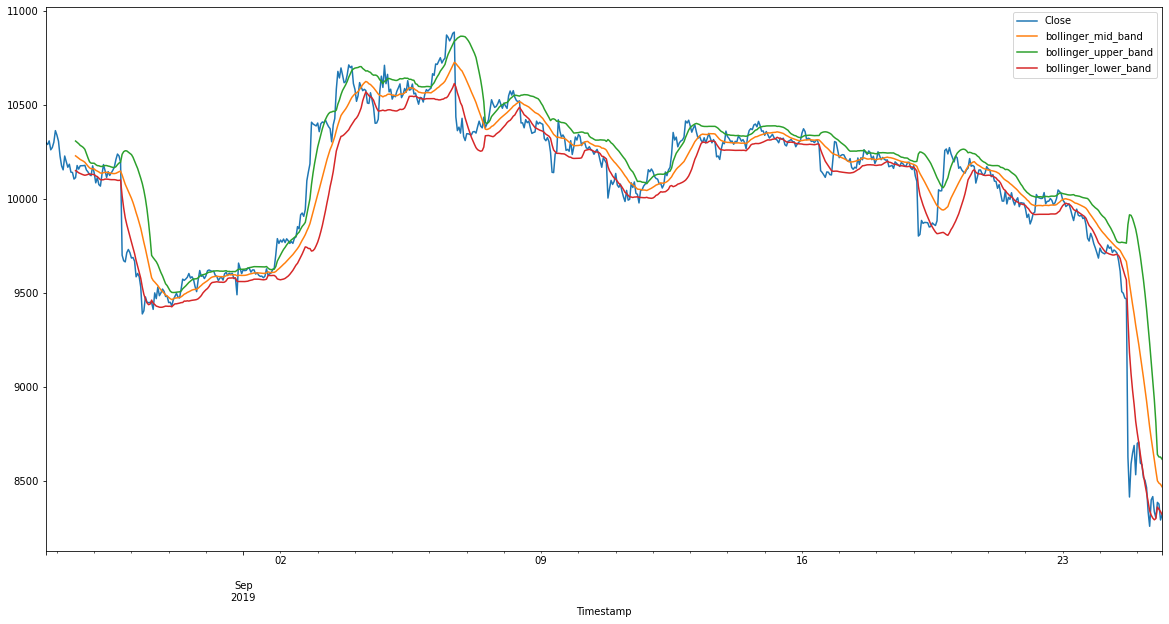

In [10]:
# Plot the Bollinger Bands for BTC/USD closing prices
btc_df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10));

# Random Forest Training

---

### Set X-Variable List and Filter to Obtain Associated Values

In [11]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal']

# Filter by x-variable list
btc_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Timestamp,,,
2019-09-25 12:00:00+00:00,-1.0,1.0,0.0
2019-09-25 13:00:00+00:00,-1.0,1.0,0.0
2019-09-25 14:00:00+00:00,-1.0,1.0,0.0
2019-09-25 15:00:00+00:00,-1.0,1.0,1.0
2019-09-25 16:00:00+00:00,-1.0,1.0,1.0


### Shift the DataFrame Index by 1

In [12]:
# Shift DataFrame values by 1
btc_df[x_var_list] = btc_df[x_var_list].shift(1)
btc_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Timestamp,,,
2019-09-25 12:00:00+00:00,-1.0,1.0,0.0
2019-09-25 13:00:00+00:00,-1.0,1.0,0.0
2019-09-25 14:00:00+00:00,-1.0,1.0,0.0
2019-09-25 15:00:00+00:00,-1.0,1.0,0.0
2019-09-25 16:00:00+00:00,-1.0,1.0,1.0


### Drop NAs and Replace Infs (Positive/Negative Infinity) 

In [13]:
# Drop NAs and replace positive/negative infinity values
btc_df.dropna(subset=x_var_list, inplace=True)
btc_df.dropna(subset=['daily_return'], inplace=True)
btc_df = btc_df.replace([np.inf, -np.inf], np.nan)
btc_df.head()

,Open,High,Low,Close,Volume,Symbol,daily_return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-08-26 18:00:00+00:00,10300.0,10305.0,10261.0,10290.9,131.790626,BTC/USD,-0.000883,10293.933333,10295.292372,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-08-26 19:00:00+00:00,10290.9,10325.1,10290.0,10310.0,78.294890,BTC/USD,0.001856,10303.114286,10300.538382,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-08-26 20:00:00+00:00,10311.5,10312.8,10147.5,10262.6,354.930190,BTC/USD,-0.004597,10281.506667,10290.046097,0.0,...,0.0,-1.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-08-26 21:00:00+00:00,10265.4,10308.1,10189.7,10274.6,570.039335,BTC/USD,0.001169,10277.941935,10286.514507,0.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-08-26 22:00:00+00:00,10274.6,10345.1,10274.6,10303.0,176.130751,BTC/USD,0.002764,10290.669841,10289.759171,1.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


### Construct the Dependent Variable

In [14]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
btc_df['Positive Return'] = np.where(btc_df['daily_return'] > 0, 1.0, 0.0)
btc_df

,Open,High,Low,Close,Volume,Symbol,daily_return,fast_close,slow_close,crossover_long,...,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Positive Return
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-08-26 18:00:00+00:00,10300.0,10305.0,10261.0,10290.9,131.790626,BTC/USD,-0.000883,10293.933333,10295.292372,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2019-08-26 19:00:00+00:00,10290.9,10325.1,10290.0,10310.0,78.294890,BTC/USD,0.001856,10303.114286,10300.538382,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2019-08-26 20:00:00+00:00,10311.5,10312.8,10147.5,10262.6,354.930190,BTC/USD,-0.004597,10281.506667,10290.046097,0.0,...,-1.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2019-08-26 21:00:00+00:00,10265.4,10308.1,10189.7,10274.6,570.039335,BTC/USD,0.001169,10277.941935,10286.514507,0.0,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2019-08-26 22:00:00+00:00,10274.6,10345.1,10274.6,10303.0,176.130751,BTC/USD,0.002764,10290.669841,10289.759171,1.0,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-25 12:00:00+00:00,8336.7,8363.9,8000.0,8305.7,1295.424881,BTC/USD,-0.003957,8336.263582,8799.354978,0.0,...,0.0,1.0,8556.905,254.811023,8811.716023,8302.093977,0.0,0.0,0.0,0.0
2019-09-25 13:00:00+00:00,8305.7,8442.5,8278.0,8388.2,459.187772,BTC/USD,0.009933,8362.231791,8771.821159,0.0,...,0.0,1.0,8502.845,139.738302,8642.583302,8363.106698,0.0,0.0,0.0,1.0
2019-09-25 14:00:00+00:00,8392.0,8478.4,8375.0,8379.0,466.040826,BTC/USD,-0.001097,8370.615896,8745.515101,0.0,...,0.0,1.0,8490.345,139.039292,8629.384292,8351.305708,0.0,0.0,0.0,0.0


In [15]:
0 == False

True

In [16]:
1==True

True

### Assign Training and Testing Windows

In [17]:
# Construct training start and end dates
training_start = btc_df.index.min().strftime(format= '%Y-%m-%d')
training_end = '2019-09-14'

# Construct testing start and end dates
testing_start =  '2019-09-15'
testing_end = btc_df.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2019-08-26
Training End: 2019-09-14
Testing Start: 2019-09-15
Testing End: 2019-09-25


### Separate X and y Training Datasets

In [18]:
# Construct the X_train and y_train datasets
X_train = btc_df[x_var_list][training_start:training_end]
y_train = btc_df['Positive Return'][training_start:training_end]

X_train.head()

,crossover_signal,vol_trend_signal,bollinger_signal
Timestamp,,,
2019-08-26 18:00:00+00:00,0.0,0.0,0.0
2019-08-26 19:00:00+00:00,-1.0,0.0,0.0
2019-08-26 20:00:00+00:00,1.0,0.0,0.0
2019-08-26 21:00:00+00:00,-1.0,-1.0,0.0
2019-08-26 22:00:00+00:00,-1.0,-1.0,0.0


In [19]:
y_train

Timestamp
2019-08-26 18:00:00+00:00    0.0
2019-08-26 19:00:00+00:00    1.0
2019-08-26 20:00:00+00:00    0.0
2019-08-26 21:00:00+00:00    1.0
2019-08-26 22:00:00+00:00    1.0
                            ... 
2019-09-14 19:00:00+00:00    0.0
2019-09-14 20:00:00+00:00    1.0
2019-09-14 21:00:00+00:00    0.0
2019-09-14 22:00:00+00:00    0.0
2019-09-14 23:00:00+00:00    1.0
Name: Positive Return, Length: 462, dtype: float64

In [20]:
y_train.tail()

Timestamp
2019-09-14 19:00:00+00:00    0.0
2019-09-14 20:00:00+00:00    1.0
2019-09-14 21:00:00+00:00    0.0
2019-09-14 22:00:00+00:00    0.0
2019-09-14 23:00:00+00:00    1.0
Name: Positive Return, dtype: float64

### Separate X and y Testing Datasets

In [21]:
# Construct the X test and y test datasets
X_test = btc_df[x_var_list][testing_start:testing_end]
y_test = btc_df['Positive Return'][testing_start:testing_end]

X_test.tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Timestamp,,,
2019-09-25 12:00:00+00:00,-1.0,1.0,0.0
2019-09-25 13:00:00+00:00,-1.0,1.0,0.0
2019-09-25 14:00:00+00:00,-1.0,1.0,0.0
2019-09-25 15:00:00+00:00,-1.0,1.0,0.0
2019-09-25 16:00:00+00:00,-1.0,1.0,1.0


In [22]:
y_test.tail()

Timestamp
2019-09-25 12:00:00+00:00    0.0
2019-09-25 13:00:00+00:00    1.0
2019-09-25 14:00:00+00:00    0.0
2019-09-25 15:00:00+00:00    0.0
2019-09-25 16:00:00+00:00    1.0
Name: Positive Return, dtype: float64

### Train Random Forest Model

In [23]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
Timestamp,,
2019-09-15 00:00:00+00:00,0.0,0.0
2019-09-15 01:00:00+00:00,1.0,0.0
2019-09-15 02:00:00+00:00,0.0,0.0
2019-09-15 03:00:00+00:00,0.0,0.0
2019-09-15 04:00:00+00:00,1.0,1.0
...,...,...
2019-09-25 12:00:00+00:00,0.0,1.0
2019-09-25 13:00:00+00:00,1.0,1.0
2019-09-25 14:00:00+00:00,0.0,1.0


### Save Pre-Trained Model Using Joblib

In [24]:
# Save the pre-trained model
dump(model, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [25]:
date_str = '8/5/2021'
date_str

'8/5/2021'

In [26]:
date_datetime = pd.to_datetime(date_str)
date_datetime

Timestamp('2021-08-05 00:00:00')

In [27]:
next_day_datetime = date_datetime + pd.Timedelta(days = 1)
next_day_datetime

Timestamp('2021-08-06 00:00:00')

In [28]:
next_day_string = next_day_datetime.strftime('%Y-%m-%d')

# Random Forest Trading

---

### Load Model and Predict y values from X_test Values

In [29]:
# Load the model and make the predictions from the X_test dataset
model = load('random_forest_model.joblib')

predictions = model.predict(X_test)
predictions

array([0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1.

### Prepare "Return" Dataframe to be merged with Predicted Results and Y_test (Actual Results)

In [30]:
# Create a daily return dataframe from original dataframe.
Return = btc_df.reset_index().rename(columns={'daily_return' : 'Return'})
Return = Return[['Timestamp','Return']].copy().set_index('Timestamp')
Return

,Return
Timestamp,
2019-08-26 18:00:00+00:00,-0.000883
2019-08-26 19:00:00+00:00,0.001856
2019-08-26 20:00:00+00:00,-0.004597
2019-08-26 21:00:00+00:00,0.001169
2019-08-26 22:00:00+00:00,0.002764
...,...
2019-09-25 12:00:00+00:00,-0.003957
2019-09-25 13:00:00+00:00,0.009933
2019-09-25 14:00:00+00:00,-0.001097


In [31]:
# Final Results Dataframe.
Results = pd.merge(Return,Results, how='inner', left_index=True, right_index=True)
Results

,Return,Positive Return,Predicted Value
Timestamp,,,
2019-09-15 00:00:00+00:00,-0.002268,0.0,0.0
2019-09-15 01:00:00+00:00,0.001944,1.0,0.0
2019-09-15 02:00:00+00:00,-0.001602,0.0,0.0
2019-09-15 03:00:00+00:00,-0.001769,0.0,0.0
2019-09-15 04:00:00+00:00,0.000920,1.0,1.0
...,...,...,...
2019-09-25 12:00:00+00:00,-0.003957,0.0,1.0
2019-09-25 13:00:00+00:00,0.009933,1.0,1.0
2019-09-25 14:00:00+00:00,-0.001097,0.0,1.0


### Plot Predicted Results vs. Actual Results

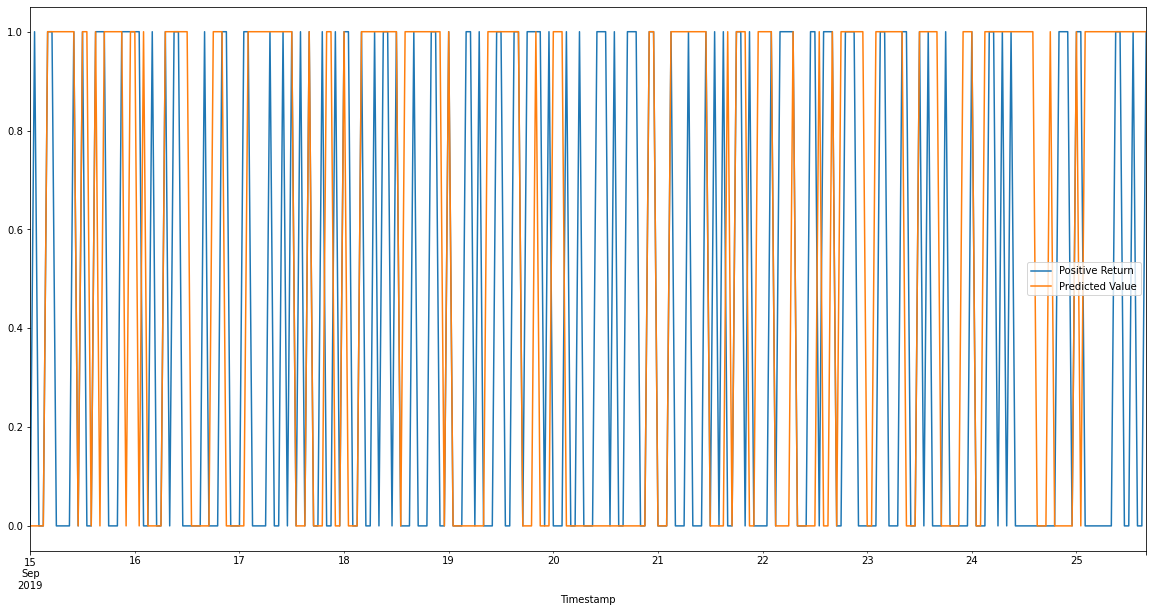

In [32]:
# Plot predicted results vs. actual results
Results[['Positive Return', 'Predicted Value']].plot(figsize=(20,10));

### Plot Predicted Results vs. Actual Results (of last 10 records)

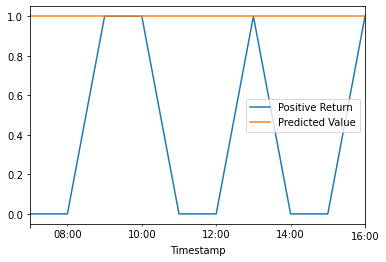

In [33]:
# Plot last 10 records of predicted vs. actual results
Results[['Positive Return', 'Predicted Value']].tail(10).plot();

### Replace Predicted Values 0 as -1 (For Shorting)

In [34]:
# Replace predicted values 0 to -1 to account for shorting
Results['Predicted Value'].replace(0, -1, inplace=True)
Results

,Return,Positive Return,Predicted Value
Timestamp,,,
2019-09-15 00:00:00+00:00,-0.002268,0.0,-1.0
2019-09-15 01:00:00+00:00,0.001944,1.0,-1.0
2019-09-15 02:00:00+00:00,-0.001602,0.0,-1.0
2019-09-15 03:00:00+00:00,-0.001769,0.0,-1.0
2019-09-15 04:00:00+00:00,0.000920,1.0,1.0
...,...,...,...
2019-09-25 12:00:00+00:00,-0.003957,0.0,1.0
2019-09-25 13:00:00+00:00,0.009933,1.0,1.0
2019-09-25 14:00:00+00:00,-0.001097,0.0,1.0


### Plot Cumulative Returns of Random Forest Model

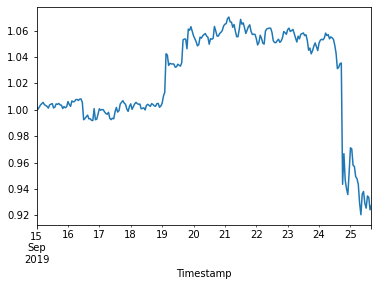

In [35]:
# Calculate cumulative return of model and plot the result
(1 + (Results['Return'] * Results['Predicted Value'])).cumprod().plot();

In [36]:
Results

,Return,Positive Return,Predicted Value
Timestamp,,,
2019-09-15 00:00:00+00:00,-0.002268,0.0,-1.0
2019-09-15 01:00:00+00:00,0.001944,1.0,-1.0
2019-09-15 02:00:00+00:00,-0.001602,0.0,-1.0
2019-09-15 03:00:00+00:00,-0.001769,0.0,-1.0
2019-09-15 04:00:00+00:00,0.000920,1.0,1.0
...,...,...,...
2019-09-25 12:00:00+00:00,-0.003957,0.0,1.0
2019-09-25 13:00:00+00:00,0.009933,1.0,1.0
2019-09-25 14:00:00+00:00,-0.001097,0.0,1.0


### Plot Cumulative Return of Random Forest Model (In Terms of Capital)

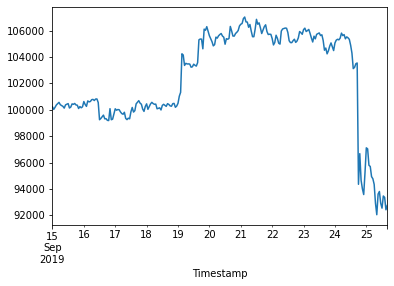

In [37]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (Results['Return'] * Results['Predicted Value'])).cumprod()
cumulative_return_capital.plot();